# Crafting adversarial samples
This notebook crafts advesrarial samples using five methods. As a result, six files are saved: one for correctly classified test images, five for adversarial examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

## Preparing dataset
Download dataset: https://datashare.ed.ac.uk/handle/10283/3192 \
Paper: [Darlow, L. N., Crowley, E. J., Antoniou, A., & Storkey, A. J. (2018). Cinic-10 is not imagenet or cifar-10. arXiv preprint arXiv:1810.03505.](https://arxiv.org/abs/1810.03505)

In [2]:
dataset_tar_path = './CINIC-10.tar.gz'
dataset_root = './cinic_root'
dataset_name = 'CINIC-10'

In [3]:
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]

In [4]:
cinic_inv_mean = [-0.47889522, -0.47227842, -0.43047404]
cinic_inv_std = [1.0/0.24205776, 1.0/0.23828046, 1.0/0.25874835]

In [4]:
import tarfile

dataset_tar = tarfile.open(dataset_tar_path)
dataset_tar.extractall(dataset_root)
dataset_tar.close()

In [5]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cinic_mean,std=cinic_std)])
# for showing images that will be crafted later
tf_denorm = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.], std=cinic_inv_std), \
                               transforms.Normalize(mean=cinic_inv_mean, std=[1., 1., 1.])])

In [6]:
classes = [
     'airplane',
     'automobile',
     'bird',
     'cat',
     'deer',
     'dog',
     'frog',
     'horse',
     'ship',
     'truck'
]

In [ ]:
import os
from random import sample

In [7]:
for class_name in classes:
    files = os.listdir('./cinic_root/test/' + class_name)
    for file in sample(files, 7500):
        os.remove('./cinic_root/test/' + class_name + '/' + file)  

"\nfor class_name in classes:\n    files = os.listdir('./cinic_root/test/' + class_name)\n    for file in sample(files, 7500):\n        os.remove('./cinic_root/test/' + class_name + '/' + file)\n"

In [8]:
test_data = ImageFolder(dataset_root + '/test', transform=tf)

In [9]:
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

Text(0.5, 0.98, 'CINIC-10')

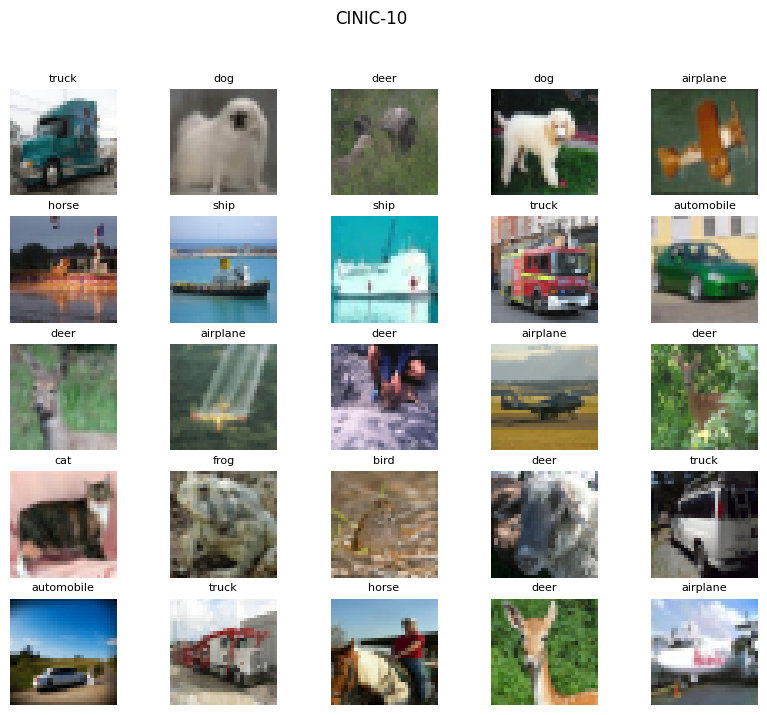

In [10]:
examples = sample(test_data.imgs, 25)

fig = plt.figure(figsize=(10, 8))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
    plt.subplot(n_rows, n_cols, index)
    plt.axis('off')
    plt.imshow(test_data.loader(examples[index - 1][0]))
    title = f'{test_data.classes[examples[index - 1][1]]}'
    plt.title(title, fontsize=8)
plt.suptitle(dataset_name)

## Preparing target model, device and loss function

In [11]:
'''
  ResNet18 from a popular repository
  url:https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
  Modification:
  * a dropout layer for randomization
'''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

'''
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
'''

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # dropout for mc-uncertainty
        self.dr = nn.Dropout(0.5)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = self.dr(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn= nn.CrossEntropyLoss()

In [13]:
model = ResNet18().to(device)
model.load_state_dict(torch.load('./resnet18_cinic_fin.pth'))

<All keys matched successfully>

## Attacks definitions
Based on: https://adversarial-attacks-pytorch.readthedocs.io/en/latest/attacks.html

In [14]:
def FGSM(model, images, labels, eps, loss_fn):
    images = images.clone().detach()
    labels = labels.clone().detach()

    images.requires_grad = True
    outputs = model(images)

    # Calculate loss
    cost = loss_fn(outputs, labels)

    # Update adversarial images
    grad = torch.autograd.grad(
                        cost, images,
                        retain_graph=False,
                        create_graph=False)[0]

    adv_images = images + eps*grad.sign()
    adv_images = torch.clamp(adv_images, min=-1, max=1).detach()

    return adv_images

In [15]:
def BIM(model, images, labels, alpha, eps, steps, loss_fn):
    original_images = images.clone().detach()
    images_min = original_images - eps
    images_max = original_images + eps

    images.requires_grad = True

    for i in range(steps):
        outputs = model(images)

        cost = loss_fn(outputs, labels)
        grad = torch.autograd.grad(
                        cost, images,
                        retain_graph=False,
                        create_graph=False)[0]

        adv_images = images + alpha * grad.sign()
        adv_images = torch.clamp(adv_images, min=images_min, max=images_max)
        images = torch.clamp(adv_images, min=-1, max=1)

    return images

In [16]:
def JSMA(model, images, labels, theta, gamma):
    images = images.clone().detach()
    labels = labels.clone().detach()
    
    target_labels = (labels + 1) % 10
    
    adv_images = None
    for im, tl in zip(images, target_labels):
        pert_image = JSMA_single(
                        model, torch.unsqueeze(im, 0),
                        torch.unsqueeze(tl, 0), theta, gamma)
        try:
            adv_images = torch.cat((adv_images, pert_image), 0)
        except Exception:
            adv_images = pert_image

    adv_images = torch.clamp(adv_images, min=-1, max=1)
    return adv_images

def JSMA_single(model, image, target_label, theta, gamma):
    var_image = image
    var_label = target_label

    if theta > 0:
        increasing = True
    else:
        increasing = False

    num_features = int(np.prod(var_image.shape[1:]))
    shape = var_image.shape

    # Perturb two pixels in one iteration, thus max_iters is divided by 2
    max_iters = int(np.ceil(num_features * gamma / 2.0))

    # Masked search domain, if the pixel has already reached the top or bottom, we don't bother to modify it
    if increasing:
        search_domain = torch.lt(var_image, 0.99)
    else:
        search_domain = torch.gt(var_image, -0.99)

    search_domain = search_domain.view(num_features)
    output = model(var_image)
    current_pred = torch.argmax(output.data, 1)

    iteration = 0
    while (iteration < max_iters) and (current_pred != target_label) and (search_domain.sum() != 0):
        # Calculate Jacobian matrix of forward derivative
        jacobian = compute_jacobian(model, var_image)
        # Get the saliency map and calculate the two pixels that have the greatest influence
        p1, p2 = saliency_map(
                    jacobian, var_label,
                    increasing, search_domain,
                    num_features)
        # Apply modifications
        # var_sample_flatten = var_image.view(-1, num_features).clone().detach_()
        var_sample_flatten = var_image.view(-1, num_features)
        var_sample_flatten[0, p1] += theta
        var_sample_flatten[0, p2] += theta

        new_image = torch.clamp(var_sample_flatten, min=-1.0, max=1.0)
        new_image = new_image.view(shape)
        search_domain[p1] = 0
        search_domain[p2] = 0
        # var_image = new_image.clone().detach().to(self.device)
        var_image = new_image

        output = model(var_image)
        current_pred = torch.argmax(output.data, 1)
        iteration += 1

    adv_image = var_image
    return adv_image

def compute_jacobian(model, image):
    var_image = image.clone().detach()
    var_image.requires_grad = True
    output = model(var_image)

    num_features = int(np.prod(var_image.shape[1:]))
    jacobian = torch.zeros([output.shape[1], num_features])
    for i in range(output.shape[1]):
        if var_image.grad is not None:
            var_image.grad.zero_()
        output[0][i].backward(retain_graph=True)
        # Copy the derivative to the target place
        jacobian[i] = var_image.grad.squeeze().view(-1, num_features).clone()  # nopep8

    return jacobian

def saliency_map(jacobian, target_label, increasing, search_space, nb_features):
    # The search domain
    domain = torch.eq(search_space, 1).float()
    # The sum of all features' derivative with respect to each class
    all_sum = torch.sum(jacobian, dim=0, keepdim=True)
    # The forward derivative of the target class
    target_grad = jacobian[target_label]
    # The sum of forward derivative of other classes
    others_grad = all_sum - target_grad

    # This list blanks out those that are not in the search domain
    if increasing:
        increase_coef = 2 * (torch.eq(domain, 0)).float()
    else:
        increase_coef = -1 * 2 * \
            (torch.eq(domain, 0)).float()
    increase_coef = increase_coef.view(-1, nb_features)

    # Calculate sum of target forward derivative of any 2 features.
    target_tmp = target_grad.clone().to(target_label.device)
    target_tmp -= increase_coef * torch.max(torch.abs(target_grad))
    # PyTorch will automatically extend the dimensions
    alpha = target_tmp.view(-1, 1, nb_features) + \
        target_tmp.view(-1, nb_features, 1)
    # Calculate sum of other forward derivative of any 2 features.
    others_tmp = others_grad.clone().to(target_label.device)
    others_tmp += increase_coef * torch.max(torch.abs(others_grad))
    beta = others_tmp.view(-1, 1, nb_features) + \
        others_tmp.view(-1, nb_features, 1)

    # Zero out the situation where a feature sums with itself
    tmp = np.ones((nb_features, nb_features), int)
    np.fill_diagonal(tmp, 0)
    zero_diagonal = torch.from_numpy(tmp).byte()

    # According to the definition of saliency map in the paper (formulas 8 and 9),
    # those elements in the saliency map that doesn't satisfy the requirement will be blanked out.
    if increasing:
        mask1 = torch.gt(alpha, 0.0)
        mask2 = torch.lt(beta, 0.0)
    else:
        mask1 = torch.lt(alpha, 0.0)
        mask2 = torch.gt(beta, 0.0)

    # Apply the mask to the saliency map
    mask = torch.mul(torch.mul(mask1, mask2), zero_diagonal.view_as(mask1).to(target_label.device))
    # Do the multiplication according to formula 10 in the paper
    saliency_map = torch.mul(
        torch.mul(alpha, torch.abs(beta)), mask.float())
    # Get the most significant two pixels
    max_idx = torch.argmax(
        saliency_map.view(-1, nb_features * nb_features), dim=1)
    # p = max_idx // nb_features
    p = torch.div(max_idx, nb_features, rounding_mode='floor')
    # q = max_idx % nb_features
    q = max_idx - p * nb_features
    return p, q

In [17]:
def DeepFool(model, images, labels, steps, overshoot):
    images = images.clone().detach()
    labels = labels.clone().detach()

    batch_size = len(images)
    correct = torch.tensor([True]*batch_size)
    target_labels = labels.clone().detach()
    curr_steps = 0

    adv_images = []
    for idx in range(batch_size):
        image = images[idx:idx+1].clone().detach()
        adv_images.append(image)

    while (True in correct) and (curr_steps < steps):
        for idx in range(batch_size):
            if not correct[idx]: continue
            early_stop, pre, adv_image = df_indiv(model, adv_images[idx], labels[idx], overshoot)
            adv_images[idx] = adv_image
            target_labels[idx] = pre
            if early_stop:
                correct[idx] = False
        curr_steps += 1

    adv_images = torch.cat(adv_images).detach()
    return adv_images


def df_indiv(model, image, label, overshoot):
    image.requires_grad = True
    fs = model(image)[0]
    _, pre = torch.max(fs, dim=0)
    if pre != label:
        return (True, pre, image)

    ws = construct_jacobian(fs, image)
    image = image.detach()

    f_0 = fs[label]
    w_0 = ws[label]

    wrong_classes = [i for i in range(len(fs)) if i != label]
    f_k = fs[wrong_classes]
    w_k = ws[wrong_classes]

    f_prime = f_k - f_0
    w_prime = w_k - w_0
    value = torch.abs(f_prime) \
            / torch.norm(nn.Flatten()(w_prime), p=2, dim=1)
    _, hat_L = torch.min(value, 0)

    delta = (torch.abs(f_prime[hat_L])*w_prime[hat_L] \
            / (torch.norm(w_prime[hat_L], p=2)**2))

    target_label = hat_L if hat_L < label else hat_L+1

    adv_image = image + (1+overshoot)*delta
    adv_image = torch.clamp(adv_image, min=-1, max=1).detach()
    return (False, target_label, adv_image)

# https://stackoverflow.com/questions/63096122/pytorch-is-it-possible-to-differentiate-a-matrix
# torch.autograd.functional.jacobian is only for torch >= 1.5.1
def construct_jacobian(y, x):
    x_grads = []
    for idx, y_element in enumerate(y):
        if x.grad is not None:
            x.grad.zero_()
        y_element.backward(retain_graph=(False or idx+1 < len(y)))
        x_grads.append(x.grad.clone().detach())
    return torch.stack(x_grads).reshape(*y.shape, *x.shape)

In [18]:
# modified for this impkementation to work correctly with normalized images

def CW(model, images, labels, c, kappa, steps, learning_rate):
    images = images.clone().detach()
    labels = labels.clone().detach()

    # w = torch.zeros_like(images).detach() # Requires 2x times
    w = inverse_tanh_space(images).detach()
    w.requires_grad = True

    best_adv_images = images.clone().detach()
    best_L2 = 1e10*torch.ones((len(images))).to(images.device)
    prev_cost = 1e10
    dim = len(images.shape)

    MSELoss = nn.MSELoss(reduction='none')
    Flatten = nn.Flatten()

    optimizer = optim.Adam([w], lr=learning_rate)

    for step in range(steps):
        # Get adversarial images
        adv_images = tanh_space(w)

        # Calculate loss
        current_L2 = MSELoss(Flatten(adv_images),
                             Flatten(images)).sum(dim=1)
        L2_loss = current_L2.sum()

        outputs = model(adv_images)
        f_loss = f(outputs, labels, kappa).sum()

        cost = L2_loss + c*f_loss

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Update adversarial images
        pre = torch.argmax(outputs.detach(), 1)
        condition = (pre != labels).float()

        # Filter out images that get either correct predictions or non-decreasing loss,
        # i.e., only images that are both misclassified and loss-decreasing are left
        mask = condition*(best_L2 > current_L2.detach())
        best_L2 = mask*current_L2.detach() + (1-mask)*best_L2

        mask = mask.view([-1]+[1]*(dim-1))
        best_adv_images = mask*adv_images.detach() + (1-mask)*best_adv_images

        # Early stop when loss does not converge.
        # max(.,1) To prevent MODULO BY ZERO error in the next step.
        if step % max(steps//10, 1) == 0:
            if cost.item() > prev_cost:
                return best_adv_images
            prev_cost = cost.item()

    return best_adv_images

def tanh_space(x):
    return torch.tanh(x)

def inverse_tanh_space(x):
    # torch.atanh is only for torch >= 1.7.0
    # atanh is defined in the range -1 to 1
    return atanh(torch.clamp(x, min=-1, max=1))

def atanh(x):
    return 0.5*torch.log((1+x)/(1-x))

# f-function in the paper
def f(outputs, labels, kappa):
    one_hot_labels = torch.eye(outputs.shape[1])[labels].to(outputs.device)

    # find the max logit other than the target class
    other = torch.max((1-one_hot_labels)*outputs, dim=1)[0]
    # get the target class's logit
    real = torch.max(one_hot_labels*outputs, dim=1)[0]

    return torch.clamp((real-other), min=-kappa)

## Functionality for running attacks and measuring model performance
First we feed test images to our model and keep only those images that were classified correctly. Then we craft adversarial examples from those images. All images are saved, and model performance is measured on clean images and advesrarial images of each type.

In [19]:
# attack parameters
params = {
    'eps': 0.05,
    'alpha': 0.005,
    'steps': 50,
    'theta': 1.0,
    'gamma': 0.1,
    'overshoot': 0.02,
    'c': 1.0,
    'kappa': 0,
    'learning_rate': 0.01
}

In [20]:
def craft_adv_samples(model, images, labels, loss_fn, params, attack):
    if attack == 'FGSM':
        pert_data = FGSM(model, images, labels, params['eps'], loss_fn)
        
    if attack == 'BIM':
        pert_data = BIM(model, images, labels, params['alpha'],
                        params['eps'], params['steps'], loss_fn)
        
    if attack == 'JSMA':
        pert_data = JSMA(model, images, labels, params['theta'], params['gamma'])
        
    if attack == 'DeepFool':
        pert_data = DeepFool(model, images, labels, params['steps'], params['overshoot'])
        
    if attack == 'CW':
        pert_data = CW(model, images, labels, params['c'],
                       params['kappa'], params['steps'],
                       params['learning_rate'])
        
    return pert_data

In [21]:
def measure_model_performance(model, test_loader, loss_fn, device, params, attack=None):
    model.eval()
    num_correct_pred = 0
    
    for X, y_true in test_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            y_hat = model(X)
        y_labels = torch.argmax(y_hat, 1)
        
        if attack != None:
            pert_data = craft_adv_samples(model, X, y_true, loss_fn, params, attack)
            with torch.no_grad():
                y_hat = model(pert_data)
            y_labels = torch.argmax(y_hat, 1)
        num_correct_pred += (y_labels == y_true).sum()

    accuracy = num_correct_pred / len(test_loader.dataset)
    return model, accuracy

In [34]:
model, test_accuracy = measure_model_performance(model, test_loader, loss_fn, device, params)
print(f'Accuracy on clean examples: {test_accuracy * 100:.2f}%')

Accuracy on clean examples: 76.79%


In [35]:
model, accuracy = measure_model_performance(model, test_loader, loss_fn, device, params, attack='FGSM')
print(f'Accuracy on FGSM examples: {accuracy * 100:.2f}%')

Accuracy on FGSM examples: 16.99%


In [36]:
model, accuracy = measure_model_performance(model, test_loader, loss_fn, device, params, attack='BIM')
print(f'Accuracy on BIM examples: {accuracy * 100:.2f}%')

Accuracy on BIM examples: 1.32%


In [22]:
model, accuracy = measure_model_performance(model, test_loader, loss_fn, device, params, attack='JSMA')
print(f'Accuracy on JSMA examples: {accuracy * 100:.2f}%')

Accuracy on JSMA examples: 0.93%


In [28]:
model, accuracy = measure_model_performance(model, test_loader, loss_fn, device, params, attack='DeepFool')
print(f'Accuracy on DeepFool examples: {accuracy * 100:.2f}%')

Accuracy on DeepFool examples: 12.78%


In [41]:
model, accuracy = measure_model_performance(model, test_loader, loss_fn, device, params, attack='CW')
print(f'Accuracy on CW examples: {accuracy * 100:.2f}%')

Accuracy on CW examples: 0.46%


In [50]:
X_clean = torch.empty((0, 3, 32, 32))
X_fgsm = torch.empty((0, 3, 32, 32))
X_bim = torch.empty((0, 3, 32, 32))
X_jsma = torch.empty((0, 3, 32, 32))
X_deepfool = torch.empty((0, 3, 32, 32))
X_cw = torch.empty((0, 3, 32, 32))

model.eval()
for X, y_true in test_loader:
    if len(X_clean) >= 10000:
        break
        
    X = X.to(device)
    y_true = y_true.to(device)
    with torch.no_grad():
        y_hat = model(X)
    y_labels = torch.argmax(y_hat, 1)

    X = X[y_labels == y_true]
    y_labels = y_labels[y_labels == y_true]
    
    pert_fgsm = FGSM(model, X, y_labels, params['eps'], loss_fn)
    pert_bim = BIM(model, X, y_labels, params['alpha'],
                   params['eps'], params['steps'], loss_fn)
    pert_jsma = JSMA(model, X, y_labels,
                     params['theta'], params['gamma'])
    pert_deepfool = DeepFool(model, X, y_labels,
                             params['steps'], params['overshoot'])
    pert_cw = CW(model, X, y_labels, params['c'],
                 params['kappa'], params['steps'], params['learning_rate'])

    X_clean = torch.cat((X_clean, X.cpu()))
    X_fgsm = torch.cat((X_fgsm, pert_fgsm.cpu()))
    X_bim = torch.cat((X_bim, pert_bim.cpu()))
    X_jsma = torch.cat((X_jsma, pert_jsma.cpu()))
    X_deepfool = torch.cat((X_deepfool, pert_deepfool.cpu()))
    X_cw = torch.cat((X_cw, pert_cw.cpu()))
    
X_clean = X_clean[:10000]
X_fgsm = X_fgsm[:10000]
X_bim = X_bim[:10000]
X_jsma = X_jsma[:10000]
X_deepfool = X_deepfool[:10000]
X_cw = X_cw[:10000]

In [25]:
import os

if not os.path.exists('data'):
    os.makedirs('data')
    
torch.save(X_clean, 'data/clean_samples.pt')
torch.save(X_fgsm, 'data/FGSM_samples.pt')
torch.save(X_bim, 'data/BIM_samples.pt')
torch.save(X_jsma, 'data/JSMA_samples.pt')
torch.save(X_deepfool, 'data/DeepFool_samples.pt')
torch.save(X_cw, 'data/CW_samples.pt')

## Demonstrating results of attacks

Text(0.5, 0.98, 'CINIC-10 FGSM examples with predictions')

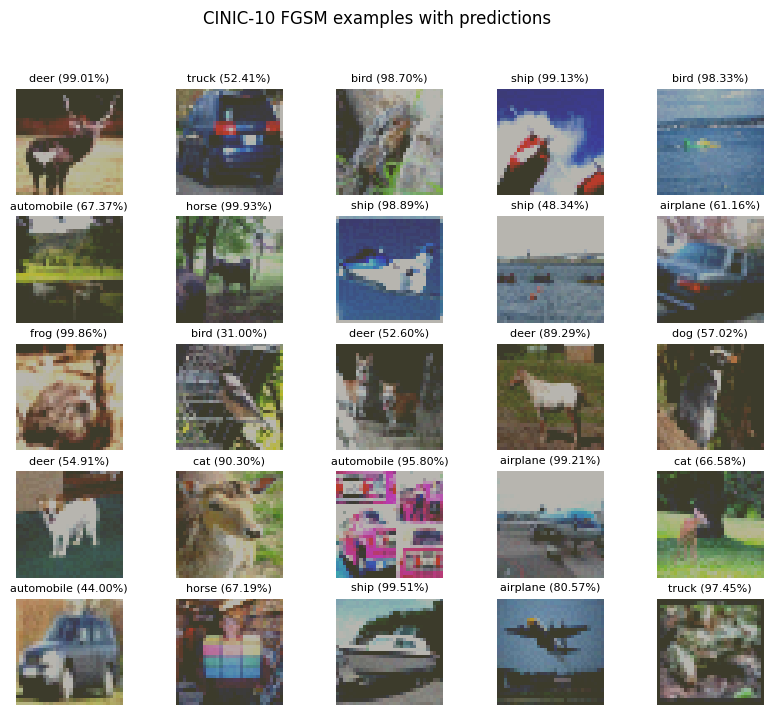

In [41]:
fig = plt.figure(figsize=(10, 8))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
    plt.subplot(n_rows, n_cols, index)
    plt.axis('off')
    plt.imshow(tf_denorm(X_fgsm[index]).movedim(0, -1).detach().numpy())
    probs = F.softmax(model(X_fgsm[index].unsqueeze(0).to(device)), dim=1)
    title = f'{test_data.classes[torch.argmax(probs, 1)]} ({torch.max(probs) * 100:.2f}%)'
    plt.title(title, fontsize=8)
plt.suptitle(dataset_name + ' FGSM examples with predictions')

Text(0.5, 0.98, 'CINIC-10 BIM examples with predictions')

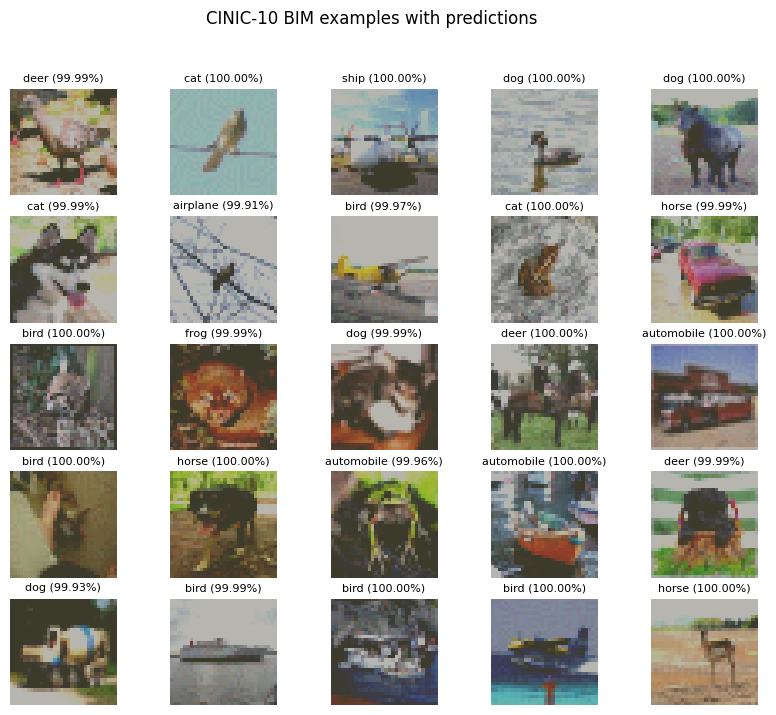

In [49]:
fig = plt.figure(figsize=(10, 8))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
    plt.subplot(n_rows, n_cols, index)
    plt.axis('off')
    plt.imshow(tf_denorm(X_bim[index]).movedim(0, -1).detach().numpy())
    probs = F.softmax(model(X_bim[index].unsqueeze(0).to(device)), dim=1)
    title = f'{test_data.classes[torch.argmax(probs, 1)]} ({torch.max(probs) * 100:.2f}%)'
    plt.title(title, fontsize=8)
plt.suptitle(dataset_name + ' BIM examples with predictions')

Text(0.5, 0.98, 'CINIC-10 JSMA examples with predictions')

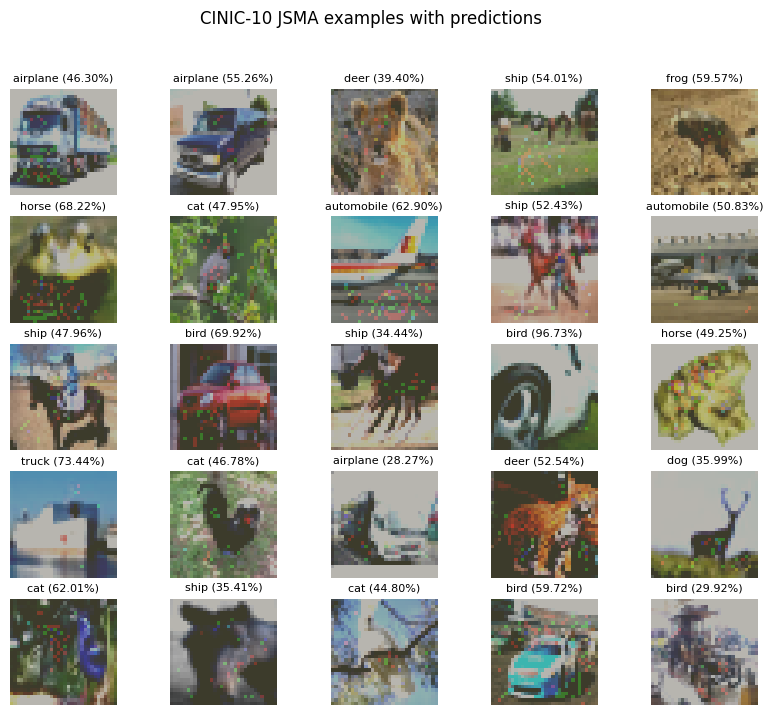

In [46]:
fig = plt.figure(figsize=(10, 8))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
    plt.subplot(n_rows, n_cols, index)
    plt.axis('off')
    plt.imshow(tf_denorm(X_jsma[index]).movedim(0, -1).detach().numpy())
    probs = F.softmax(model(X_jsma[index].unsqueeze(0).to(device)), dim=1)
    title = f'{test_data.classes[torch.argmax(probs, 1)]} ({torch.max(probs) * 100:.2f}%)'
    plt.title(title, fontsize=8)
plt.suptitle(dataset_name + ' JSMA examples with predictions')

Text(0.5, 0.98, 'CINIC-10 DeepFool examples with predictions')

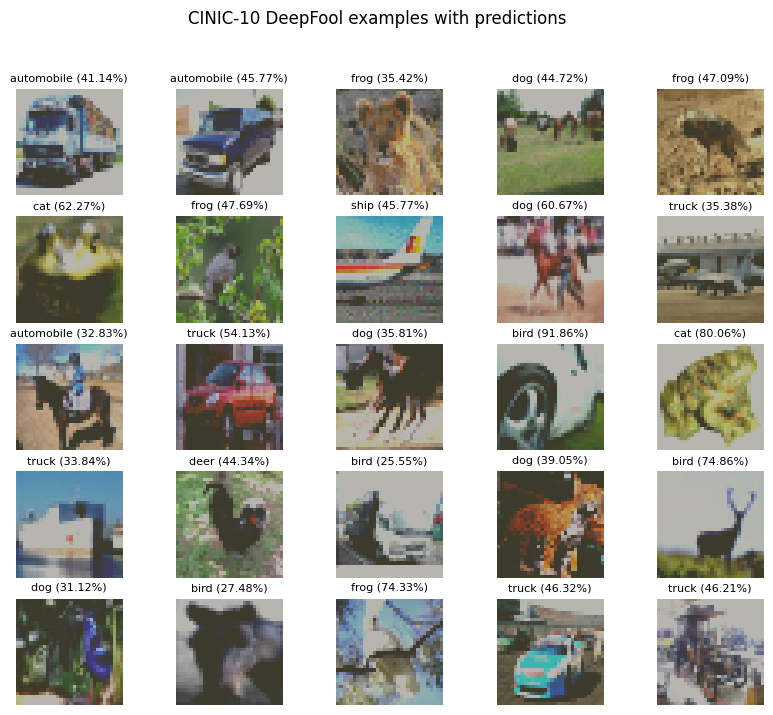

In [47]:
fig = plt.figure(figsize=(10, 8))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
    plt.subplot(n_rows, n_cols, index)
    plt.axis('off')
    plt.imshow(tf_denorm(X_deepfool[index]).movedim(0, -1).detach().numpy())
    probs = F.softmax(model(X_deepfool[index].unsqueeze(0).to(device)), dim=1)
    title = f'{test_data.classes[torch.argmax(probs, 1)]} ({torch.max(probs) * 100:.2f}%)'
    plt.title(title, fontsize=8)
plt.suptitle(dataset_name + ' DeepFool examples with predictions')

Text(0.5, 0.98, 'CINIC-10 CW examples with predictions')

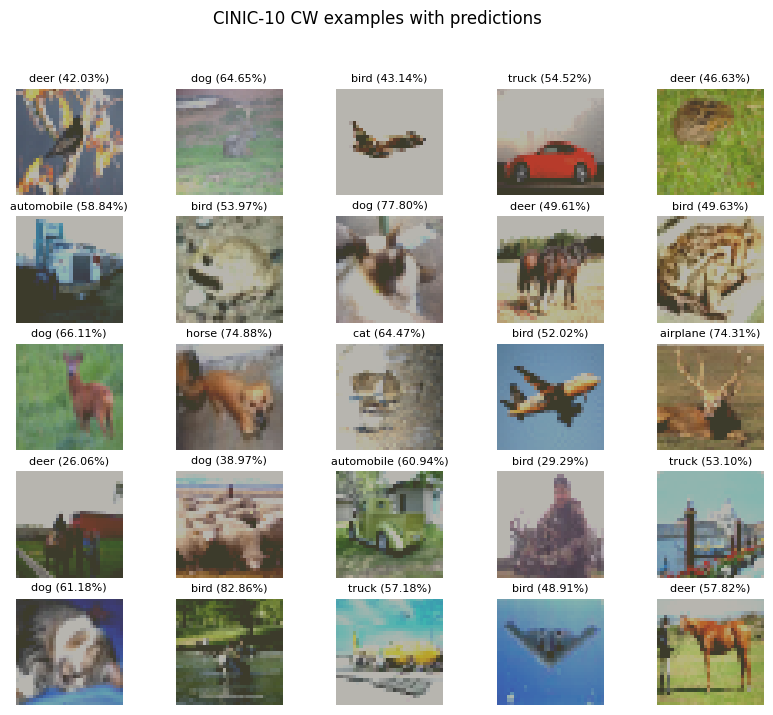

In [51]:
fig = plt.figure(figsize=(10, 8))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
    plt.subplot(n_rows, n_cols, index)
    plt.axis('off')
    plt.imshow(tf_denorm(X_cw[index]).movedim(0, -1).detach().numpy())
    probs = F.softmax(model(X_cw[index].unsqueeze(0).to(device)), dim=1)
    title = f'{test_data.classes[torch.argmax(probs, 1)]} ({torch.max(probs) * 100:.2f}%)'
    plt.title(title, fontsize=8)
plt.suptitle(dataset_name + ' CW examples with predictions')